# 0.0. IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import datetime
import seaborn as sns
import xgboost as xgb

from scipy                 import stats as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, 6)):
        if verbose:
            print( '\nKFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance 
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame({'Model_Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round( np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round( np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round( np.std(rmse_list), 2).astype(str)}, index=[0])

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y ) 

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE': mae, 
                          'MAPE': mape, 
                          'RMSE': rmse}, index=[0] )

def cramer_v(x,y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )

    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [69]:
#jupyter_settings() 

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('../Datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../Datasets/store.csv', low_memory=False)

# merge data
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRIÇÂO DOS DADOS

In [5]:
df01 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df01.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df01.shape[0]))
print('Number of Cols: {}'.format(df01.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df01['date'] = pd.to_datetime(df01['date'])

df01.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df01.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
df01.isna().sum()/df01.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5. Fillout NA

In [11]:
# competition_distance
df01['competition_distance'] = df01['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df01['competition_open_since_month'] = df01.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],
    axis=1
)

# competition_open_since_year
df01['competition_open_since_year'] = df01.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],
    axis=1
)

# promo2_since_week
df01['promo2_since_week'] = df01.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],
    axis=1
)

# promo2_since_year
df01['promo2_since_year'] = df01.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],
    axis=1
)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df01['promo_interval'].fillna(0, inplace=True)

df01['month_map'] = df01['date'].dt.month.map(month_map)

df01['is_promo'] = df01[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,
    axis=1
)

In [12]:
df01.sample(5).T

,778274,479189,897277,272289,265843
store,790,525,488,452,570
day_of_week,6,1,4,7,7
date,2013-08-03 00:00:00,2014-04-28 00:00:00,2013-04-18 00:00:00,2014-11-23 00:00:00,2014-11-30 00:00:00
sales,7850,13149,2626,0,0
customers,754,1012,336,0,0
open,1,1,1,0,0
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,d,d,a,a,a


In [14]:
df01.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [17]:
df01['competition_open_since_month'] = df01['competition_open_since_month'].astype(np.int64)
df01['competition_open_since_year'] = df01['competition_open_since_year'].astype(np.int64)

df01['promo2_since_week'] = df01['promo2_since_week'].astype(np.int64)
df01['promo2_since_year'] = df01['promo2_since_year'].astype(np.int64)

In [18]:
df01.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [19]:
num_attributes = df01.select_dtypes(include=['int64', 'float64'])

cat_attributes = df01.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [21]:
# Central Tendency - mean. median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T
                  
# concatenate
df1 = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
df1.columns = ['attrbiutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skw', 'kurtosis']

In [22]:
df1

,attrbiutes,min,max,range,mean,median,std,skw,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


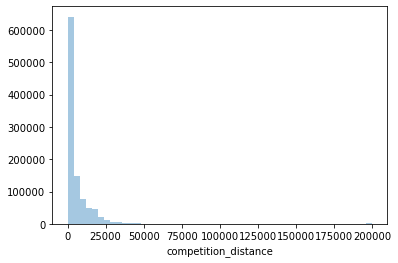

In [31]:
sns.distplot(df01['competition_distance'], kde=False);

### 1.7.2. Categorical Attributes

In [32]:
# categorical attributes levels
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

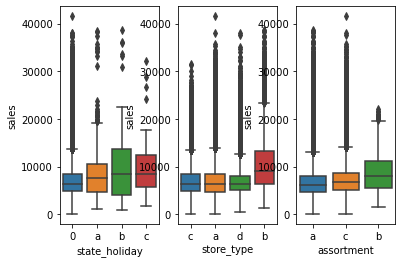

In [33]:
aux01 = df01[(df01['state_holiday'] != 0) & (df01['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux01);

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux01);

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux01);

# 2.0. FEATURE ENGINEERING

In [65]:
df02 = df01.copy()

## 2.1. Hypothesis Mind Map

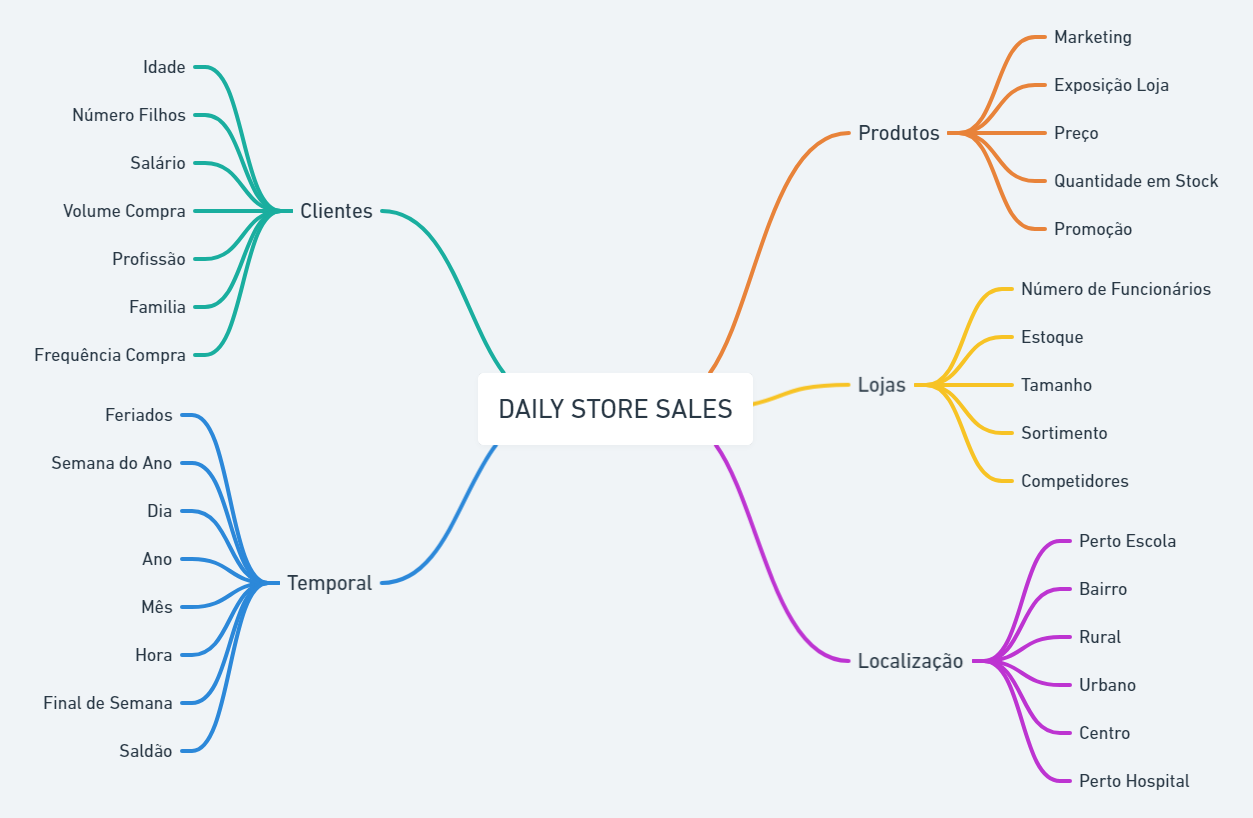

In [17]:
Image('../Images/MindMapHypothesis.png')

# adicionar estações do ano em temporal

# revisar presença de saldão em temporal

## 2.2. Create Hypothesis

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveraim vender mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveraim vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [68]:
# year
df02['year'] = df02['date'].dt.year

# month
df02['month'] = df02['date'].dt.month

# day
df02['day'] = df02['date'].dt.day

# week of year
df02['week_of_year'] = df02['date'].dt.isocalendar().week.astype(np.int64)

# year week
df02['year_week'] = df02['date'].dt.strftime('%Y-%W')


# competition since
df02['competition_since'] = df02.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                          month=x['competition_open_since_month'],
                                                          day=1), axis=1)

df02['competition_time_month'] = ((df02['date'] - df02['competition_since'])/30).apply(lambda x: x.days).astype(np.int64)

# promo since
df02['promo_since'] = df02['promo2_since_year'].astype(str) + '-' + df02['promo2_since_week'].astype(str)
df02['promo_since'] = df02['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df02['promo_time_week'] = ((df02['date'] - df02['promo_since'])/7 ).apply(lambda x: x.days).astype(np.int64)

# assortment
df02['assortment'] = df02['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df02['state_holiday'] = df02['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [71]:
df02.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [72]:
df03 = df02.copy()

## 3.1. Filtragem das Linhas

In [74]:
df03 = df03[(df03['open'] != 0) & (df03['sales'] > 0)]

## 3.2. Seleção das Colunas

In [76]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df03 = df03.drop(cols_drop, axis=1)

# 4.0. ANALISE EXPLORATÓRIA DOS DADOS

In [78]:
df04 = df03.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


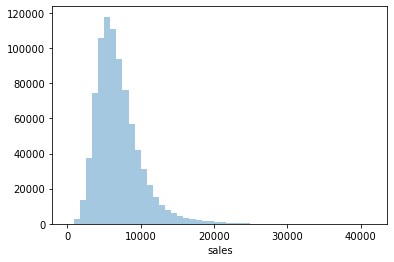

In [54]:
sns.distplot(df04['sales'], kde=False);

In [55]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


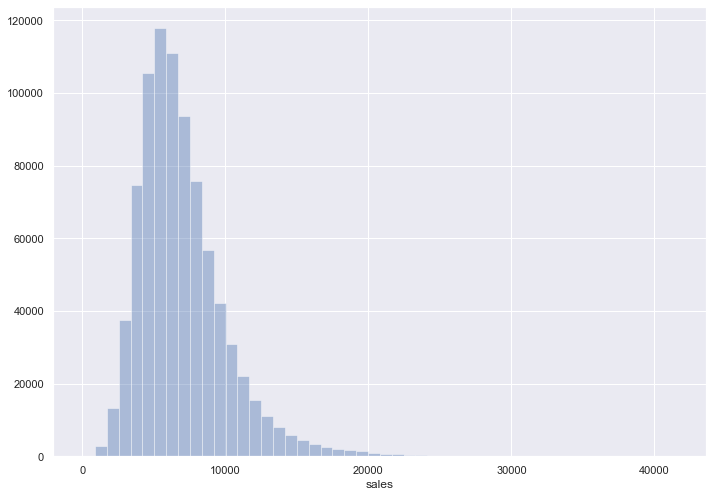

In [56]:
sns.distplot(df04['sales'], kde=False);

### 4.1.2. Numerical Variable

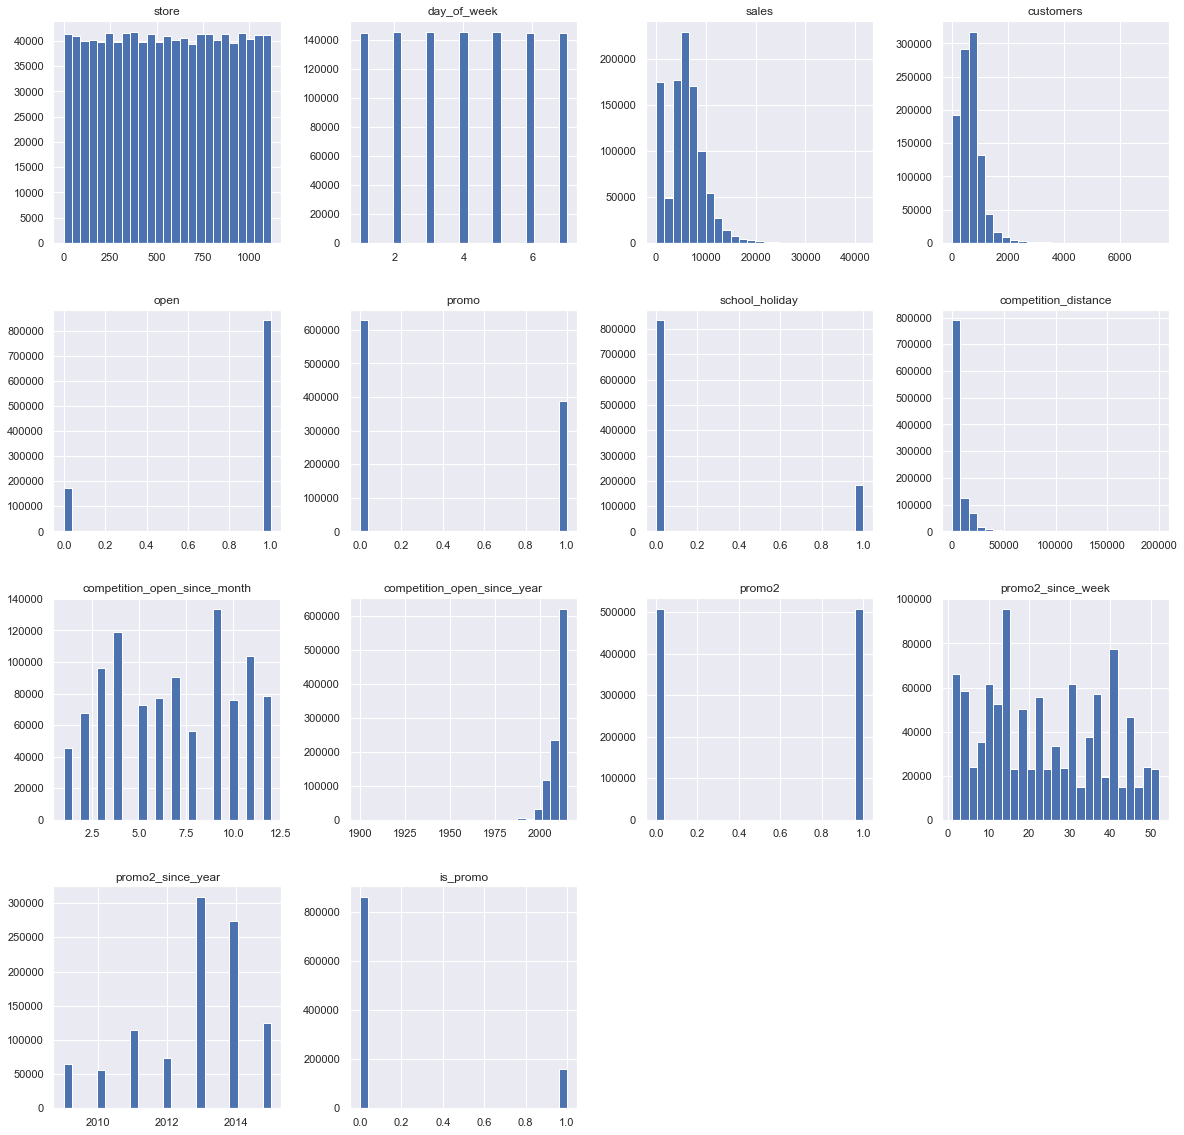

In [58]:
num_attributes.hist(bins=25, figsize=(20,20));

### 4.1.3. Categorical Variable

In [39]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

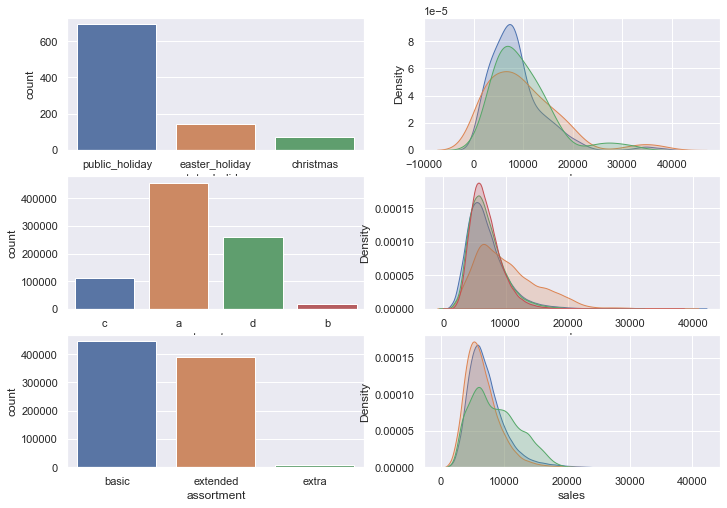

In [59]:
#state_holiday
plt.subplot(3, 2, 1)
a = df04[df04['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df04[df04['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df04[df04['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df04[df04['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df04['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df04[df04['store_type'] == 'a']['sales'], label='type a', shade=True);
sns.kdeplot(df04[df04['store_type'] == 'b']['sales'], label='type b', shade=True);
sns.kdeplot(df04[df04['store_type'] == 'c']['sales'], label='type c', shade=True);
sns.kdeplot(df04[df04['store_type'] == 'd']['sales'], label='type d', shade=True);

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df04['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df04[df04['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df04[df04['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df04[df04['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO venden MENOS.



Meigarom : Lojas com assortment menor vende menos, assumindo que extra são assortment maiores.]
           Será que houve alguma mudança de comportamento durante o tempo.
           Sempre olhe o eixo y, se algum valor for muito discrepante, vale a pena plotar separado
           

Vinicius: Calcula a soma acumulada total e não a média ou mediana.


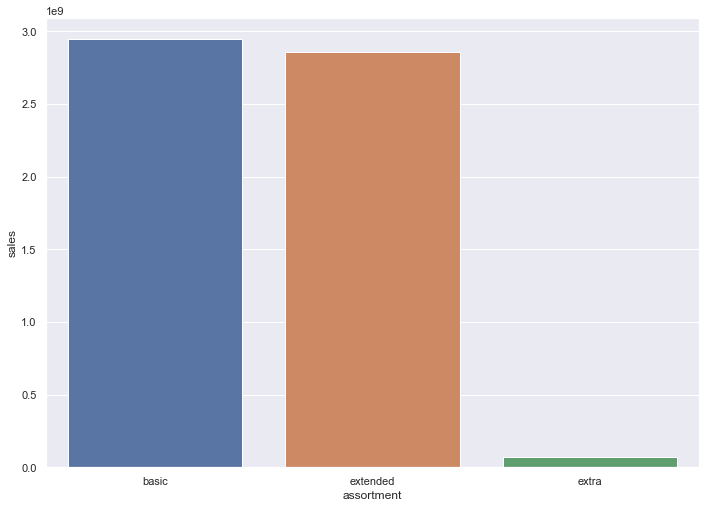

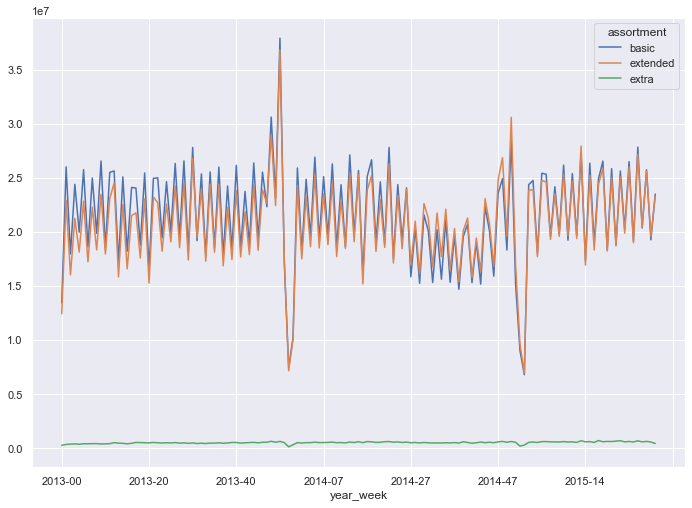

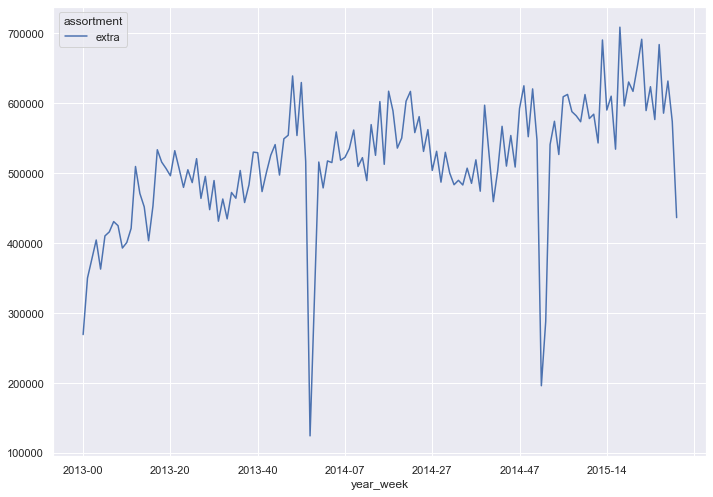

In [67]:
aux1 = df04[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df04[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.



Meigarom : Agregar os competition distance em grupos
           Pode ser macroeeconomico, se voce tem mais pessoas oferencendo o mesmo produto em regioes proximas, você icentiva o cosnumo.
           Esse é um tipo de insights.

Vinicius: Calcula a soma acumulada total e não a média ou mediana.


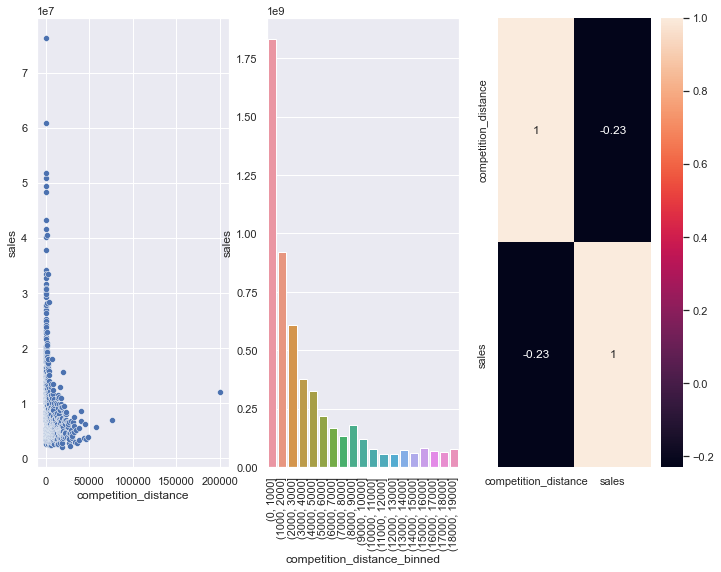

In [75]:
aux1 = df04[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins= list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSE** Lojas com COMPETIDORES à mais tempo VENDEM MENOS.

Filtar com os primeiros 120 meses e diferente de 0

Mais recente mais agente vende

Vinicius: Calcula a soma acumulada total e não a média ou mediana.

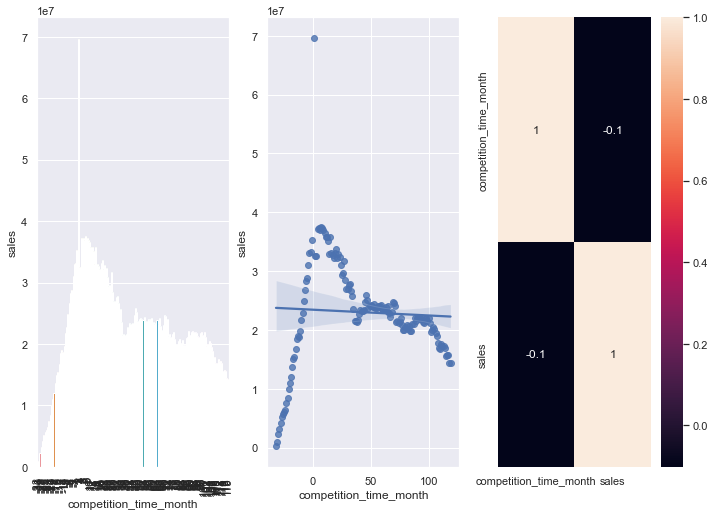

In [81]:
plt.subplot(1, 3, 1)
aux1 = df04[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas pro mais tempo vendem menos, depois de um certo periodo de promoção.

selecionar colunas com promo=1 ou promo2 = 1, significa selecionar dados com promoções ativas.

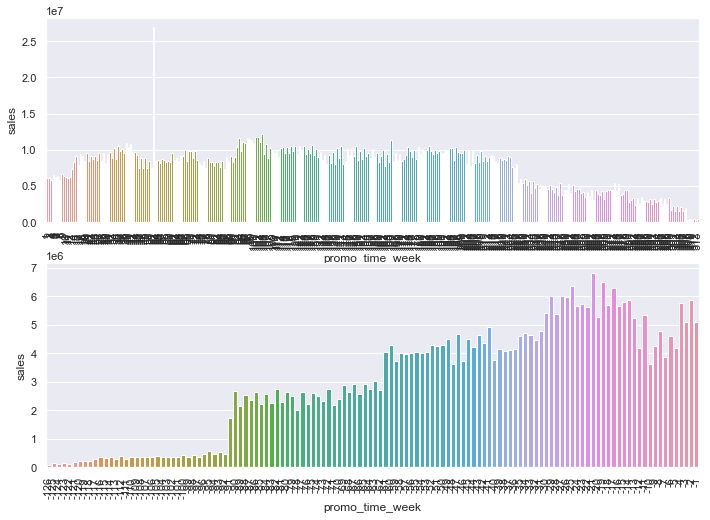

In [86]:
aux1 = df04[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)
#sns.barplot(x='promo_time_week', y='sales', data=aux1);

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>  **H5.** Lojas com mais dias de promoção deveriam vender mais. </s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

Fazer 3 axes com tradicional & extendida, extendida, e tradicional

In [89]:
df04[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


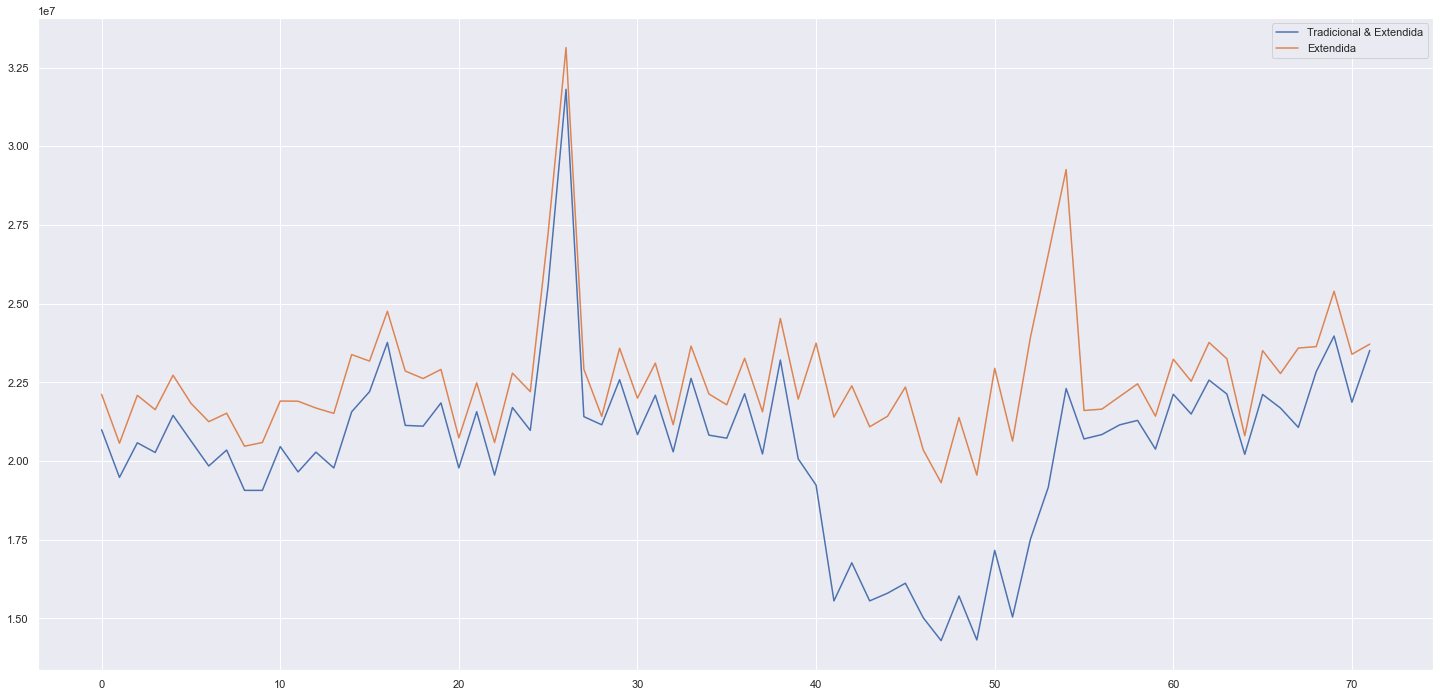

In [204]:
# analise de comportamento durante o tempo
aux1 = df04[(df04['promo'] == 1) & (df04['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df04[(df04['promo'] == 1) & (df04['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem menos.

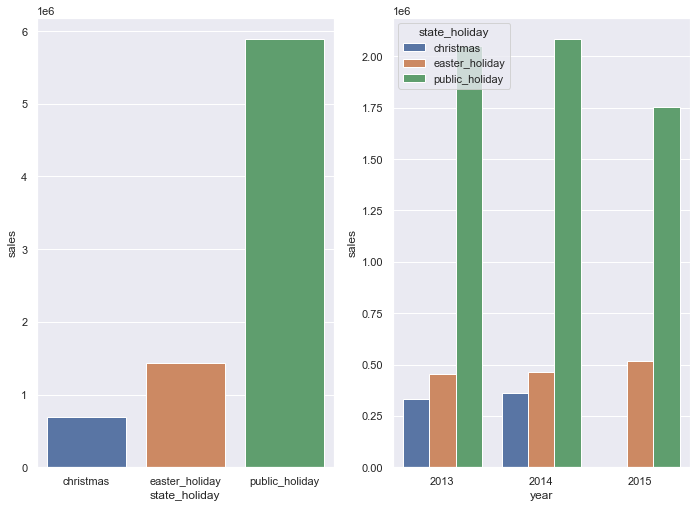

In [97]:
aux = df04[df04['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux = df04[df04['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

2015 não é o ano completo

verificar inicio e fim dos dados -> adicionar nas dimensões dos dados

adicionar dados a conclusão, por exemplo, porcentagens


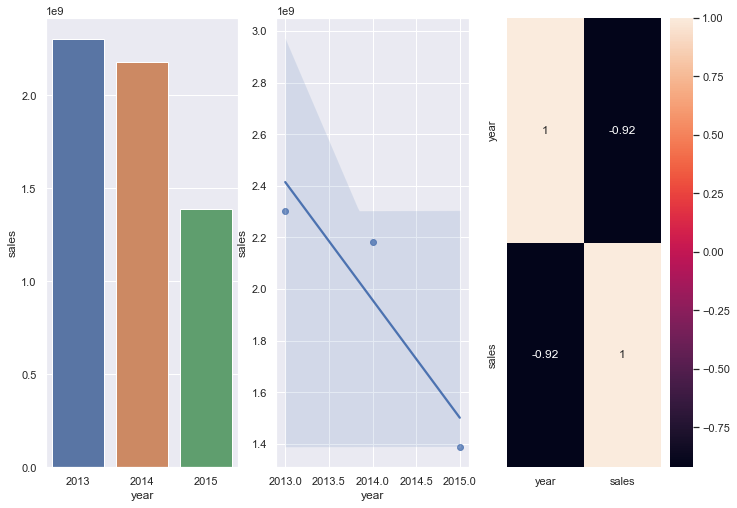

In [101]:
aux1 = df04[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano.

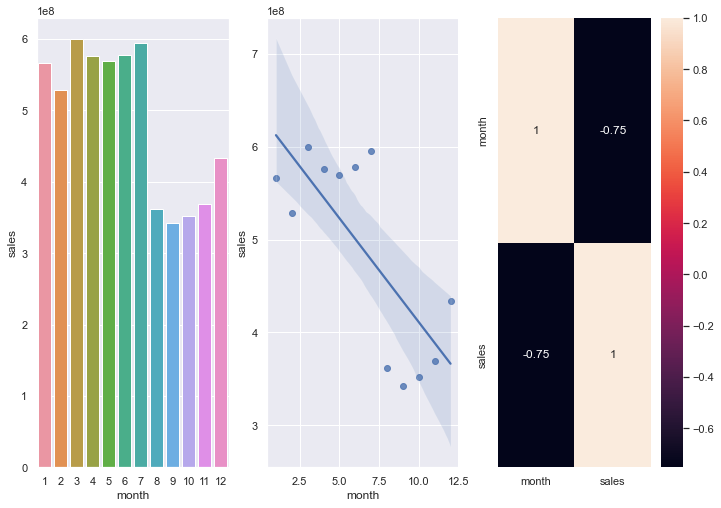

In [102]:
aux1 = df04[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem menos ao longo dos ano.

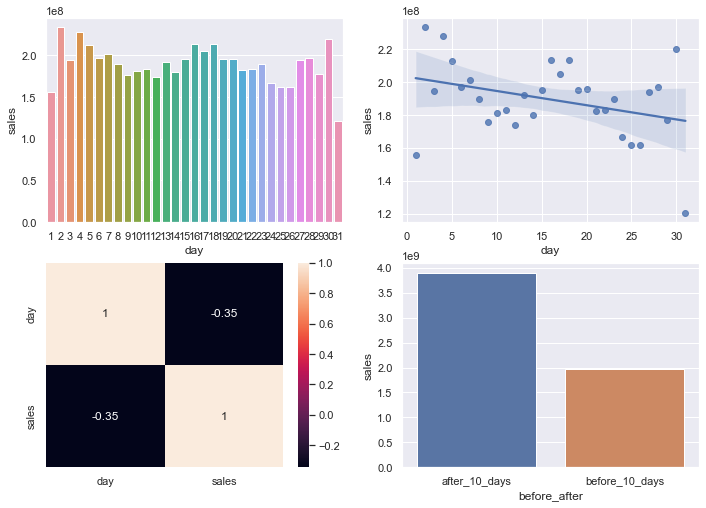

In [107]:
aux1 = df04[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**FALSA** Lojas vendem menos nos finais de semana.

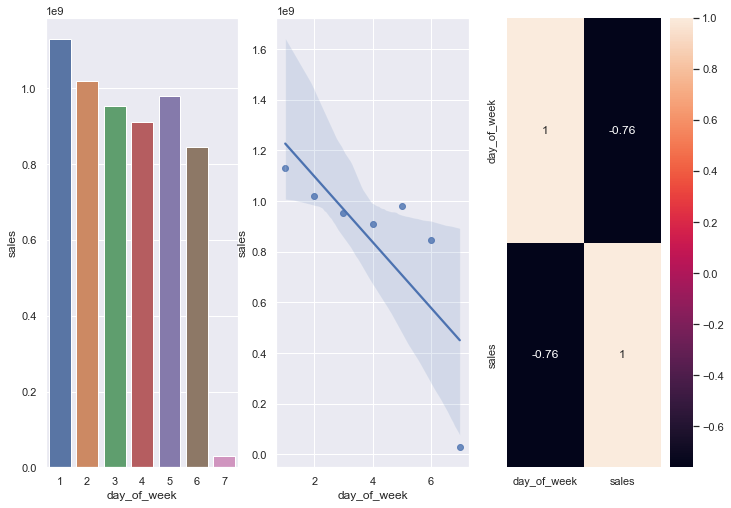

In [111]:
aux1 = df04[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

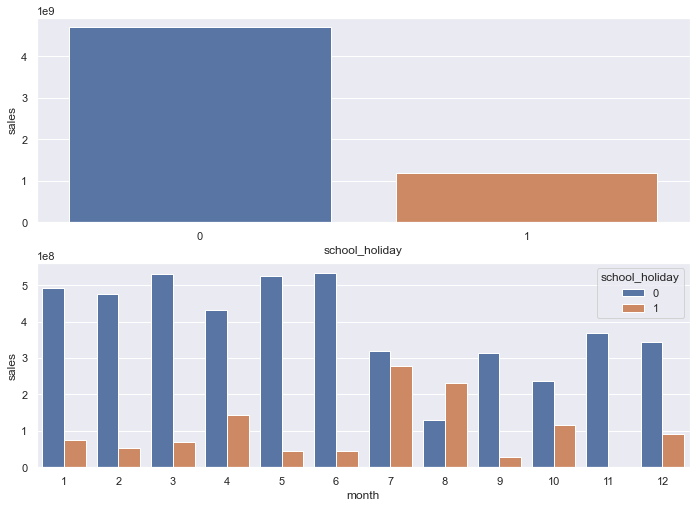

In [115]:
aux1 = df04[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 =df04[['school_holiday', 'month', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipóteses

In [117]:
from tabulate import tabulate

tab =[
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa']
]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

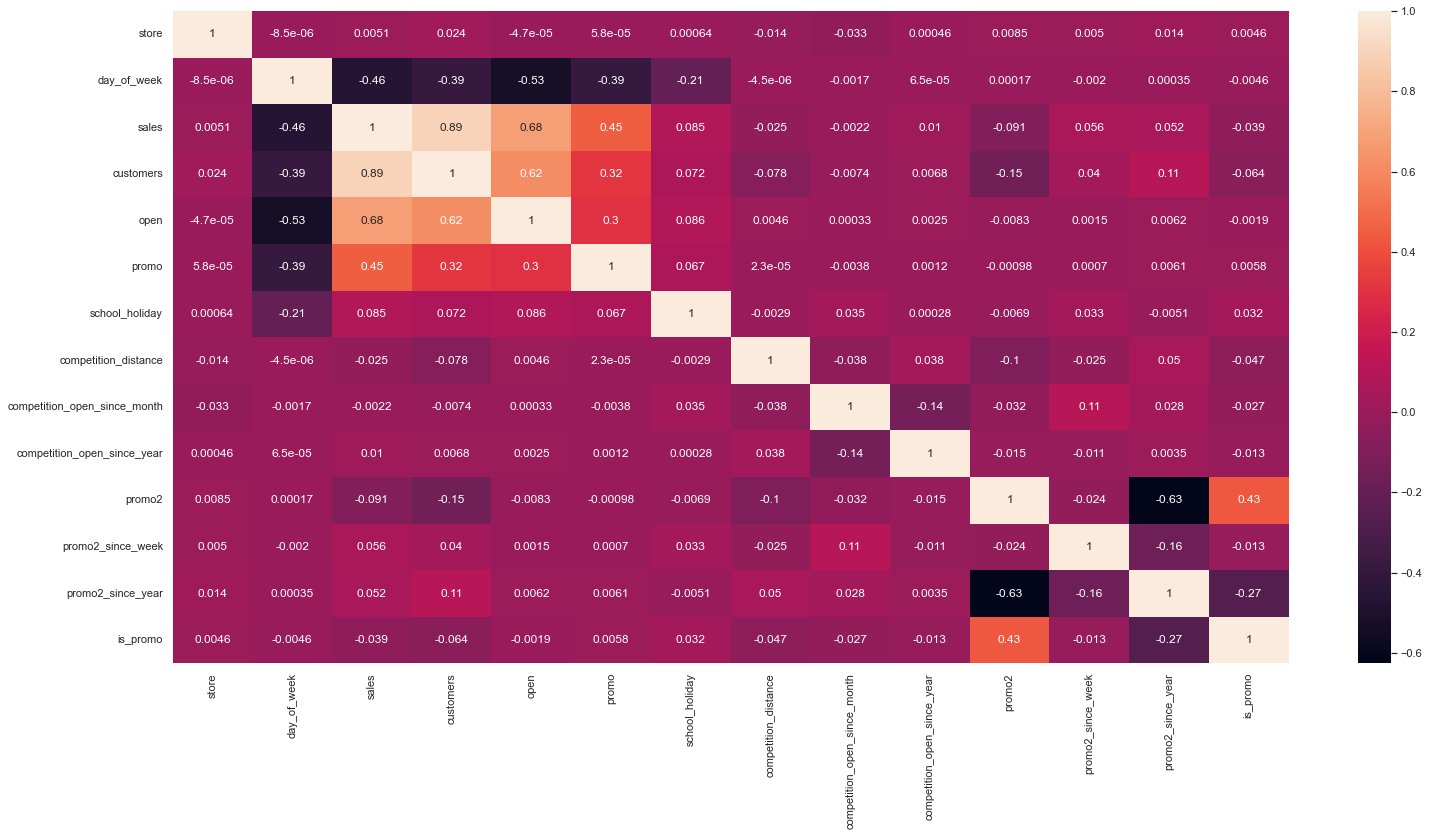

In [154]:
correlation = num_attributes.corr(method='pearson')

sns.set(rc={'figure.figsize':(25,12)})

sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

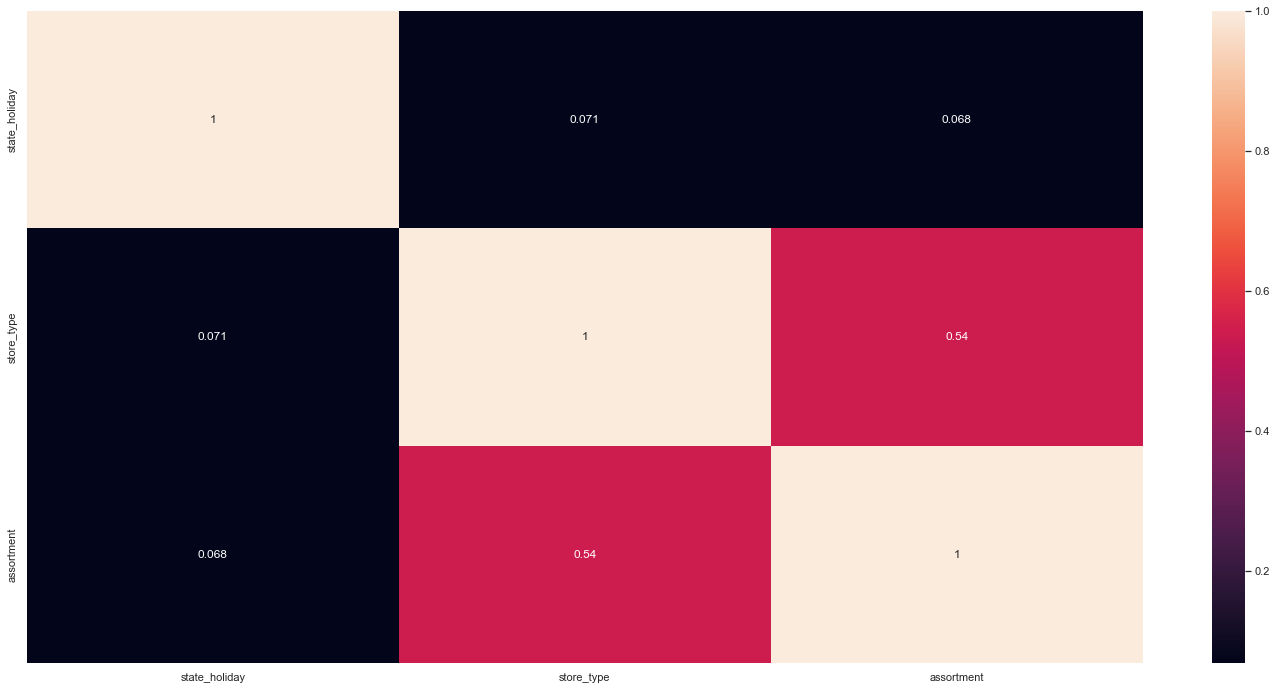

In [155]:
# select categorical data
a = df04.select_dtypes(include='object')

# calculate cramer V

# state_holiday
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

# store_type
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

# assortment
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final dataset
d= pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

# heatmap
sns.heatmap(d, annot=True);

# 5.0. Data Preparation

In [93]:
df05 = df04.copy()

## 5.1. Normarlizacao

In [26]:
# não possui variaveis com a distribuição normal

## 5.2. Rescaling

In [92]:
a = df05.select_dtypes(include=['int64', 'float64'])

C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

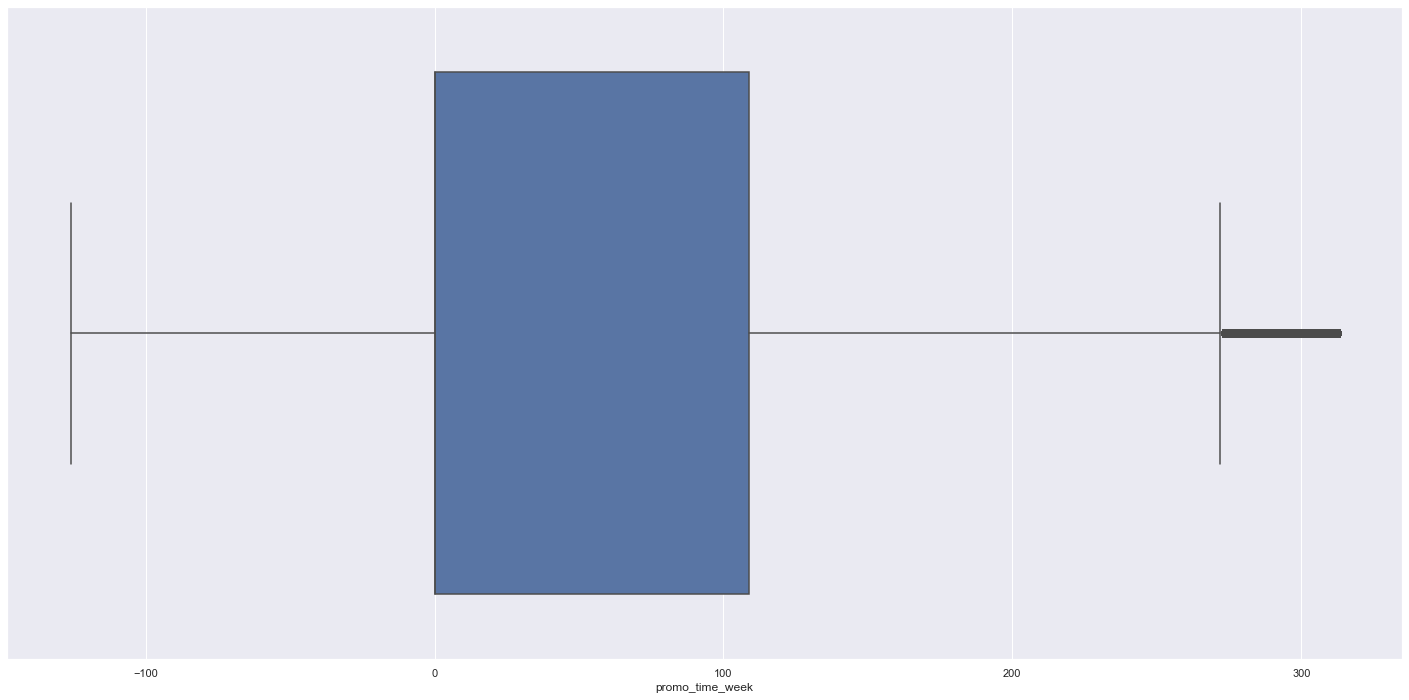

In [179]:
sns.boxplot(df05['promo_time_week'])

In [94]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df05['competition_distance'] = rs.fit_transform(df05[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition time month
df05['competition_time_month'] = rs.fit_transform(df05[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo time week
df05['promo_time_week'] = mms.fit_transform(df05[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df05['year'] = mms.fit_transform(df05[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

C:\Users\Ganso\anaconda3\envs\Drugstore-Sales-Forecast\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


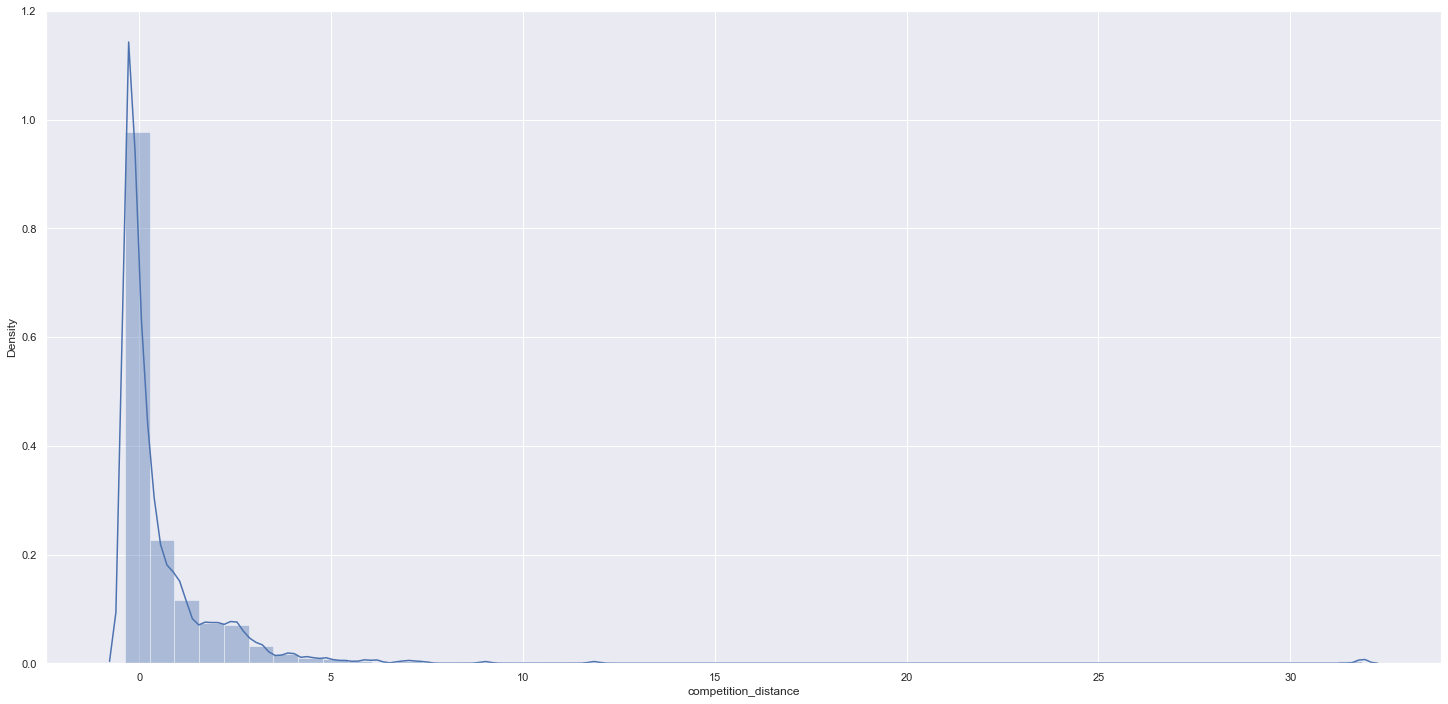

In [193]:
sns.distplot(df05['competition_distance']);

## 5.3. Transformation

### 5.3.1. Encoding

In [95]:
# state_holiday - One Hot Encoding
df05 = pd.get_dummies(df05, prefix=['state_holiday'], columns=['state_holiday'], dtype=np.int64)

In [96]:
# store_type - Label Encoding
le = LabelEncoder()
df05['store_type'] = le.fit_transform(df05['store_type']).astype(np.int64)
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

In [97]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df05['assortment'] = df05['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [98]:
df05['sales'] = np.log1p(df05['sales'])

### 5.3.3. Nature Transformation

In [99]:
# day of week
df05['day_of_week_sin'] = df05['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df05['day_of_week_cos'] = df05['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df05['month_sin'] = df05['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df05['month_cos'] = df05['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df05['day_sin'] = df05['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df05['day_cos'] = df05['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df05['week_of_year_sin'] = df05['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df05['week_of_year_cos'] = df05['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [100]:
df05.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [101]:
df05.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

# 6.0. Data Selection

In [103]:
df06 = df05.copy()

## 6.1. Split dataframe into training and test dataset

In [104]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df06 = df06.drop(cols_drop, axis=1)

In [105]:
df06[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [106]:
# training dataset
X_train = df06[df06['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df06[df06['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(( X_train['date'].min())))
print('Training Max Date: {}'.format(( X_train['date'].max())))

print('\nTraining Min Date: {}'.format(( X_test['date'].min())))
print('Training Max Date: {}'.format(( X_test['date'].max())))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [218]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [107]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #boruta.support_weak_

# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [103]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos']

In [ ]:
cols_not_selected_boruta = ['is_promo',
                            'month_sin',
                            'school_holiday',
                            'state_holiday_christmas',
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday',
                            'state_holiday_regular_day',
                            'week_of_year_sin',
                            'year']

## 6.3. Manual Feature Selection

In [108]:
## 6.3. Manual Feature Selection
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance', 
                        'competition_open_since_month',
                        'competition_open_since_year', 
                        'promo2', 
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month',
                        'promo_time_week', 
                        'day_of_week_sin', 
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos', 
                        'day_sin', 
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODELLING

In [109]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training  = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [40]:
aux1 = x_test.copy() 
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [41]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [42]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

lr_result_cv

,Model_Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [43]:
# model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso -Cross Validation

In [44]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )

lrr_result_cv

,Model_Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [45]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [51]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )

rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model_Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5. XGBoost Regressor

In [52]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,857.809468,0.125117,1260.20886


### 7.5.1. XGBoost Regressor - Cross Validation

In [50]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )

xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model_Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [53]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,857.809468,0.125117,1260.208860
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2.Real Performance - Cross Validation

In [54]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv
#modelling_result.sort_values('RMSE')

,Model_Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [59]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [57]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] ) 
    
final_result

{'n_estimators': 3500, 'eta': 0.001, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}


KeyboardInterrupt: 

In [58]:
final_result

,Model_Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,811.06 +/- 114.57,0.11 +/- 0.01,1172.91 +/- 164.15


## 8.2. Final Model

In [133]:
param_tuned = {'n_estimators': 3000,
               'eta': 0.03,
               'max_depth': 5,
               'subsample': 0.7 ,
               'colsample_bytree': 0.7 ,
               'min_child_weight': 3 }

In [134]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )

# prediction 
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned
pickle.dump( model_xgb_tuned, open( '../Model/model_rossmann.pkl', 'wb' ) )

In [102]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

mpe

# se negativo esta superestimando o valor 

In [105]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '../Model/model_rossmann.pkl', 'wb' ) )

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [106]:
df09 = X_test[ cols_selected_boruta_full ]

# rescale
df09['sales'] = np.expm1( df09['sales'] )
df09['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [107]:
# sum of predictions
df09_aux1 = df09[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df09_aux2 = df09[['store', 'sales', 'predictions']].groupby('store').apply( 
    lambda x: mean_absolute_error(x['sales'], x['predictions']) 
).reset_index().rename( columns={0:'MAE'} )

df09_aux3 = df09[['store', 'sales', 'predictions']].groupby('store').apply( 
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']) 
).reset_index().rename( columns={0:'MAPE'} )

# join MAE and MAPE data
df09_aux4 = pd.merge( df09_aux2, df09_aux3, how='inner', on='store' )
df09_aux5 = pd.merge( df09_aux1, df09_aux4, how='inner', on='store' )

# scenarios
df09_aux5['worst_scenario'] = df09_aux5['predictions'] - df09_aux5['MAE']
df09_aux5['best_scenario'] = df09_aux5['predictions'] + df09_aux5['MAE']

# order columns
df09_aux5 = df09_aux5[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [121]:
df09_aux6 = df09[['store', 'store_type', 'assortment', 'competition_distance']].groupby('store').min()

df09_aux7 = pd.merge( df09_aux5 , df09_aux6, how='inner', on='store')

In [122]:
df09_aux5.sort_values('MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106009.968750,102744.870233,109275.067267,3265.098517,0.557336
908,909,242143.828125,234542.369204,249745.287046,7601.458921,0.520058
875,876,201142.343750,197099.465523,205185.221977,4042.878227,0.311338
721,722,359919.531250,357740.516918,362098.545582,2179.014332,0.290853
273,274,195346.093750,193969.956867,196722.230633,1376.136883,0.239868
...,...,...,...,...,...,...
1040,1041,226932.718750,226555.245856,227310.191644,377.472894,0.058204
561,562,739651.250000,738733.626885,740568.873115,917.623115,0.051707
1088,1089,383049.218750,382537.870988,383560.566512,511.347762,0.050274
258,259,534342.812500,533682.663086,535002.961914,660.149414,0.050264


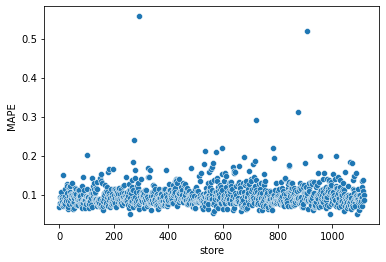

In [110]:
sns.scatterplot(x='store', y='MAPE', data=df09_aux5);

## 9.2. Total Performance

In [111]:
df093 = df09_aux5[['predictions', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0
).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})

df093['Values'] = df093['Values'].map( 'R${:,.2f}'.format )

df093

,Scenario,Values
0,predictions,"R$286,060,608.00"
1,worst_scenario,"R$285,310,439.14"
2,best_scenario,"R$286,810,720.20"


## 9.3. Machine Learning Performance

In [112]:
df09['error'] = df09['sales'] - df09['predictions']
df09['error_rate'] = df09['predictions'] / df09['sales']

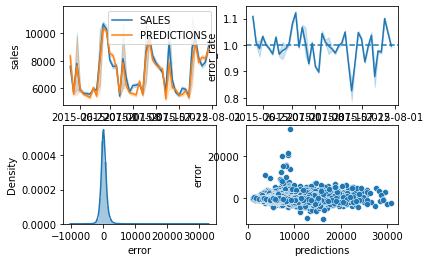

In [113]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df09, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df09, label='PREDICTIONS' );

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df09 )
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3)
sns.distplot(df09['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(df09['predictions'], df09['error']);

In [114]:
df09_aux7[['store_type', 'MAPE']].groupby('store_type').mean().reset_index()

,store_type,MAPE
0,0,0.100891
1,1,0.089391
2,2,0.100233
3,3,0.095194


In [115]:
df09_aux7[['assortment', 'MAPE']].groupby('assortment').mean().reset_index()

,assortment,MAPE
0,1,0.101346
1,2,0.091320
2,3,0.096098


# 10.0. DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save Trained Model
picke.dump(model_xgb_tuner, open('../Model/model_rossmann'))

## 10.1. Rossmann Class

In [19]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = r'C:\Users\Ganso\Documents\Data-Science\repos\Drugstore-Sales-Forecast\Notebooks'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '/parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '/parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '/parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + '/parameter/year_scaler.pkl', 'rb' ) )       
        self.store_type_scaler             = pickle.load( open( self.home_path + '/parameter/store_type_scaler.pkl', 'rb' ) )
        
    def data_cleaning(self, df01):

        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
                    'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df01.columns = cols_new

        ## 1.3. Data Types

        df01['date'] = pd.to_datetime(df01['date'])

        ## 1.5. Fillout NA

        # competition_distance
        df01['competition_distance'] = df01['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df01['competition_open_since_month'] = df01.apply(
            lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],
            axis=1
        )

        # competition_open_since_year
        df01['competition_open_since_year'] = df01.apply(
            lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],
            axis=1
        )

        # promo2_since_week
        df01['promo2_since_week'] = df01.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],
            axis=1
        )

        # promo2_since_year
        df01['promo2_since_year'] = df01.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],
            axis=1
        )

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df01['promo_interval'].fillna(0, inplace=True)

        df01['month_map'] = df01['date'].dt.month.map(month_map)

        df01['is_promo'] = df01[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,
            axis=1
        )

        ## 1.6. Change Types

        df01['competition_open_since_month'] = df01['competition_open_since_month'].astype(np.int64)
        df01['competition_open_since_year'] = df01['competition_open_since_year'].astype(np.int64)

        df01['promo2_since_week'] = df01['promo2_since_week'].astype(np.int64)
        df01['promo2_since_year'] = df01['promo2_since_year'].astype(np.int64)
        
        return df01


    def feature_engineering( self, df02):

        # year
        df02['year'] = df02['date'].dt.year

        # month
        df02['month'] = df02['date'].dt.month

        # day
        df02['day'] = df02['date'].dt.day

        # week of year
        df02['week_of_year'] = df02['date'].dt.isocalendar().week

        # year week
        df02['year_week'] = df02['date'].dt.strftime('%Y-%W')


        # competition since
        df02['competition_since'] = df02.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                  month=x['competition_open_since_month'],
                                                                  day=1), axis=1)

        df02['competition_time_month'] = ((df02['date'] - df02['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df02['promo_since'] = df02['promo2_since_year'].astype(str) + '-' + df02['promo2_since_week'].astype(str)
        df02['promo_since'] = df02['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df02['promo_time_week'] = ((df02['date'] - df02['promo_since'])/7 ).apply(lambda x: x.days).astype(int)

        # assortment
        df02['assortment'] = df02['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df02['state_holiday'] = df02['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        df02.head().T

        # 3.0. FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df02 = df02[df02['open'] != 0]

        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']

        df02 = df02.drop(cols_drop, axis=1)
        
        return df02
    
    def data_preparation( self, df05):

        # competition_distance
        df05['competition_distance'] = self.competition_distance_scaler.fit_transform(df05[['competition_distance']].values)


        # competition time month
        df05['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df05[['competition_time_month']].values)

        # promo time week
        df05['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df05[['promo_time_week']].values)
        
        # year
        df05['year'] = self.year_scaler.fit_transform(df05[['year']].values)

        # state_holiday - One Hot Encoding
        df05 = pd.get_dummies(df05, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df05['store_type'] = self.store_type_scaler.fit_transform(df05['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df05['assortment'] = df05['assortment'].map(assortment_dict)

        ### 5.3.2. Response Variable Transformation

        df05['sales'] = np.log1p(df05['sales'])

        ### 5.3.3. Nature Transformation

        # day of week
        df05['day_of_week_sin'] = df05['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df05['day_of_week_cos'] = df05['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df05['month_sin'] = df05['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df05['month_cos'] = df05['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df05['day_sin'] = df05['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df05['day_cos'] = df05['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df05['week_of_year_sin'] = df05['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df05['week_of_year_cos'] = df05['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                         'competition_open_since_month','competition_open_since_year', 'promo2', 
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos','month_sin',
                         'month_cos', 'day_sin', 'day_cos','week_of_year_sin','week_of_year_cos']
        
        return df05[ cols_selected ]
    
    def get_prediction(self, model, originial_data, test_data):
        # prediction
        pred = model.predict(test_data)

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [21]:
import pandas as pd
from flask import Flask

#from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( r'C:\Users\Ganso\Documents\Data-Science\repos\Drugstore-Sales-Forecast\Model\model_rossmann.pkl', 'rb' ) )

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def roosmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://10.0.0.101:5000/ (Press CTRL+C to quit)


## 10.3. API Tester

In [114]:
import requests

In [34]:
import flask

In [45]:
import json

In [110]:
# loading test dataset
df10 = pd.read_csv('../Datasets/test.csv')

In [135]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]
#df_test = df_test[df_test['Store'].isin( [24, 12, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [136]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [145]:
# API Call
url = 'http://10.0.0.101:5000/rossmann/predict/'
header = {'content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print( 'Status Code {}'.format(r.status_code))

Status Code 404


In [139]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

JSONDecodeError: [Errno Expecting value] <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>
: 0

In [ ]:
d2 = d1 [['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
          d2.loc[i, 'store'],
          d2.loc[i, 'prediction']))
    

### 10.3.1. Deployed API Tester

In [110]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [117]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [118]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 22 will sell R$154,065.04 in the next 6 weeks
